In [1]:
%pip install tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\ANJA\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
#Dataset
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

<h1 style="color: #ab5bb0">Ucitavanje podataka: - STARO</h1>

In [285]:
"""
train_val_data_dir = r'..\images\train'
#train_val_data_dir = path + r'\images\train'
img_height = 48
img_width = 48
batch_size = 128

# train DS
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',  # subfolderi - labele
    label_mode='categorical',   # labele - kao one hot encod
    validation_split=0.2, 
    subset = 'training',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
    #interpolation='bilinear' # opciono - metod, kod nas ne radimo resizing
)

train_class_names = train_ds.class_names
print(train_class_names)  

# validation DS (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',     
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
)

val_class_names = val_ds.class_names
print(val_class_names) 


# test DS
test_data_dir = r'..\images\test'
#test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)
"""

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


<h1>NOVO UCITAVANJE PODATAKA SA OVERSAMPLINGOM ZA DISGUST</h1>

In [299]:
#dodato novo sa oversamplingom
import tensorflow as tf
import numpy as np
import os
import random

# --- Parametri ---
train_val_data_dir = r'..\images\train'
img_height = 48
img_width = 48
batch_size = 128
target_class = 'disgust'
target_count = 4000

# --- Učitaj sve slike u memoriju (kao test DS, bez split) ---
all_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=1,   # batch=1 da dobijemo pojedinačne slike
    shuffle=True,
    color_mode='grayscale'
)

class_names = all_ds.class_names
num_classes = len(class_names)
target_idx = class_names.index(target_class)
print("Sve klase:", class_names)

# --- Razdvoji slike po klasama ---
images_per_class = {i: [] for i in range(num_classes)}
labels_per_class = {i: [] for i in range(num_classes)}

for img, lbl in all_ds.unbatch():
    cls_idx = tf.argmax(lbl).numpy()
    images_per_class[cls_idx].append(img.numpy())
    labels_per_class[cls_idx].append(lbl.numpy())

# --- Oversampling ciljne klase ---
current_count = len(images_per_class[target_idx])
if current_count < target_count:
    extra_idx = np.random.choice(current_count, target_count - current_count, replace=True)
    for i in extra_idx:
        images_per_class[target_idx].append(images_per_class[target_idx][i])
        labels_per_class[target_idx].append(labels_per_class[target_idx][i])

# --- Spoji sve klase ---
all_images = []
all_labels = []
for i in range(num_classes):
    all_images.extend(images_per_class[i])
    all_labels.extend(labels_per_class[i])

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# --- Permutacija da batch-evi budu mešani ---
perm = np.random.permutation(len(all_images))
all_images = all_images[perm]
all_labels = all_labels[perm]

# --- Stratified split 80/20 po klasama ---
train_images, val_images = [], []
train_labels, val_labels = [], []

for cls in range(num_classes):
    cls_indices = np.where(np.argmax(all_labels, axis=1) == cls)[0]
    split_idx = int(len(cls_indices) * 0.8)
    train_idx = cls_indices[:split_idx]
    val_idx = cls_indices[split_idx:]
    
    train_images.append(all_images[train_idx])
    train_labels.append(all_labels[train_idx])
    val_images.append(all_images[val_idx])
    val_labels.append(all_labels[val_idx])

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)
val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# --- Permutacija nakon split-a ---
perm_train = np.random.permutation(len(train_images))
train_images = train_images[perm_train]
train_labels = train_labels[perm_train]

perm_val = np.random.permutation(len(val_images))
val_images = val_images[perm_val]
val_labels = val_labels[perm_val]

# --- Kreiraj batch-eve kao image_dataset_from_directory ---
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))  # shuffle pre batch-a
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.shuffle(buffer_size=len(val_images))  # opcionalno, obično se ne shuffle val
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


train_ds.class_names = class_names
val_ds.class_names = class_names

print("Train shape:", train_images.shape, train_labels.shape)
print("Val shape:", val_images.shape, val_labels.shape)


Found 28821 files belonging to 7 classes.
Sve klase: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train shape: (25906, 48, 48, 1) (25906, 7)
Val shape: (6479, 48, 48, 1) (6479, 7)


In [300]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [301]:
# test DS
batch_size = 128
test_data_dir = r'..\images\test'
#test_data_dir = path + r'\images\validation'
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',       
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=False  #da se ne mijesa redolsijed podataka
)

test_class_names = test_ds.class_names
print(test_class_names)

Found 7066 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


Broj slika u originalnom datasetu:
        
        - training 28821
        
        - validation (test kod nas) 7066

In [224]:
def show_first_images_by_category_grayscale(dataset): 
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        #class_names = train_ds.class_names
    
        first_of_class = {}  # prva slika po klasi
    
        for i in range(len(images)):
            class_index = np.argmax(labels[i])
            class_name = class_names[class_index]
    
            if class_name not in first_of_class:
                first_of_class[class_name] = images[i]
    
            if len(first_of_class) == len(class_names):
                break
    
        # broj klasa
        n_classes = len(class_names)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona
    
        for ax, (class_name, image) in zip(axes, first_of_class.items()):
            ax.imshow(image.squeeze(), cmap='gray')  # squeeze ako je grayscale
            ax.set_title(class_name)
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

In [225]:
# Metoda koja prikazuje po jednu sliku iz svake kategorije - rgb 
def show_first_images_by_category_rgb(dataset):   
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        #class_names = train_ds.class_names
    
        first_of_class = {}  # prva slika po klasi
    
        for i in range(len(images)):
            class_index = np.argmax(labels[i])
            class_name = class_names[class_index]
    
            if class_name not in first_of_class:
                first_of_class[class_name] = images[i]
    
            if len(first_of_class) == len(class_names):
                break
    
        # broj klasa
        n_classes = len(class_names)
        fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*2, 2))  # 1 red, n_classes kolona
    
        for ax, (class_name, image) in zip(axes, first_of_class.items()):
            ax.imshow(image) 
            ax.set_title(class_name)
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

<h3 style="color: #ab5bb0">Prebrojavanje slika po kategorijama:</h3>

In [286]:
def count_labels(dataset):
    counts = dict.fromkeys(class_names, 0)
    for _, labels in dataset:
        indices = np.argmax(labels, axis=1)
        for i in indices:
            counts[class_names[i]] += 1
    return counts



print("Train dataset:", count_labels(train_ds))
print("Validation dataset:", count_labels(val_ds))
print("Test dataset:", count_labels(test_ds))


Train dataset: {'Angry': 3229, 'Disgust': 341, 'Fear': 3294, 'Happy': 5765, 'Sad': 3941, 'Surprise': 3935, 'Neutral': 2552}
Validation dataset: {'Angry': 764, 'Disgust': 95, 'Fear': 809, 'Happy': 1399, 'Sad': 1041, 'Surprise': 1003, 'Neutral': 653}
Test dataset: {'Angry': 960, 'Disgust': 111, 'Fear': 1018, 'Happy': 1825, 'Sad': 1216, 'Surprise': 1139, 'Neutral': 797}


<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - nisu jos normalizovane niti konv. u rgb</h3>

In [287]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

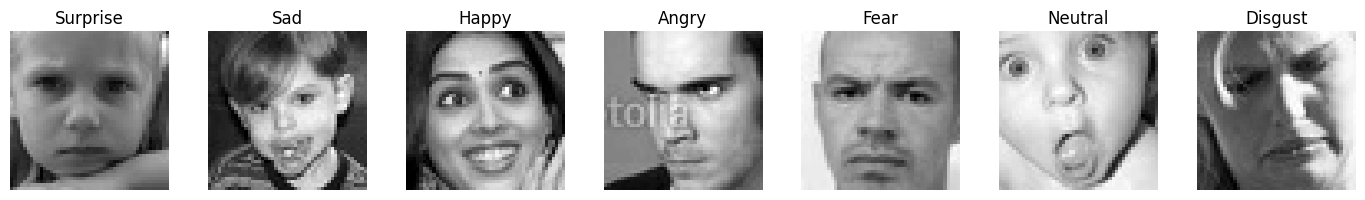

In [288]:
show_first_images_by_category_grayscale(train_ds)

<h4>Normalizacija:</h4>

In [289]:
def normalize_images(x, y):
    x = tf.cast(x, tf.float32)
    x = (x - 0) / (255 - 0)      # min-max normalizacija
    return x, y

# primjena na sve dataset-ove
train_ds = train_ds.map(normalize_images)
val_ds   = val_ds.map(normalize_images)
test_ds  = test_ds.map(normalize_images)

In [290]:
for x, y in train_ds.take(1):
    print(x.shape)  # (batch_size, img_height, img_width, 1)

(128, 48, 48, 1)


Provjera px:

Train set - Min pixel: 0.0, Max pixel: 1.0
Validation set - Min pixel: 0.0, Max pixel: 1.0
Test set - Min pixel: 0.0, Max pixel: 1.0


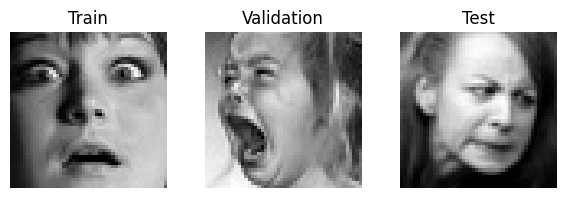

In [291]:
# Metoda koja prikazuje po 1 sliku iz train test i validation skupova
def show_first_images_in_row(train_ds, val_ds, test_ds):
    datasets = [train_ds, val_ds, test_ds]
    names = ["Train", "Validation", "Test"]
    images_to_show = []

    # uzmi prvu sliku iz svakog skupa
    for dataset, name in zip(datasets, names):
        for images, labels in dataset.take(1):
            image = images[0].numpy().squeeze()  # prva slika
            min_val = tf.reduce_min(images).numpy()
            max_val = tf.reduce_max(images).numpy()
            print(f"{name} set - Min pixel: {min_val}, Max pixel: {max_val}")
            images_to_show.append((image, name))

    # prikaz slika u jednom redu
    fig, axes = plt.subplots(1, len(images_to_show), figsize=(len(images_to_show)*2, 2))
    for ax, (image, name) in zip(axes, images_to_show):
        ax.imshow(image, cmap='gray')
        ax.set_title(name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_first_images_in_row(train_ds, val_ds, test_ds)

<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - normalizovane, nisu konv. u rgb</h3>

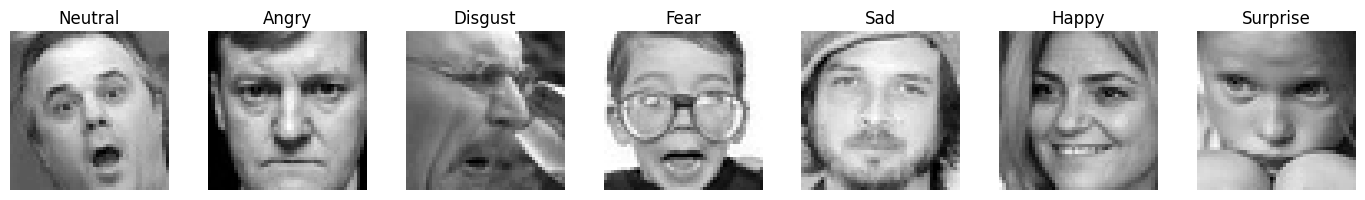

In [292]:
show_first_images_by_category_grayscale(train_ds)

Augmentacija train seta:

In [293]:
# Data augmentation - pozvati u modelu
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    # layers.RandomZoom(0.2)
])

<h4>GRAYSLACE TO RGB:</h4>

In [294]:
def preprocess_to_rgb(img, label):
    img = tf.image.grayscale_to_rgb(img)  # 1 kanal -> 3 kanala
    return img, label

train_ds_rgb = train_ds.map(preprocess_to_rgb)
val_ds_rgb = val_ds.map(preprocess_to_rgb)
test_ds_rgb = test_ds.map(preprocess_to_rgb)

for x, y in train_ds_rgb.take(1):
    print(x.shape)  # (batch_size, img_height, img_width, 3)


(128, 48, 48, 3)


<h3 style="color: #ab5bb0">Prikaz prvih slika po kategorijama iz prvog batch-a: (random) - normalizovane, konv. u rgb</h3>

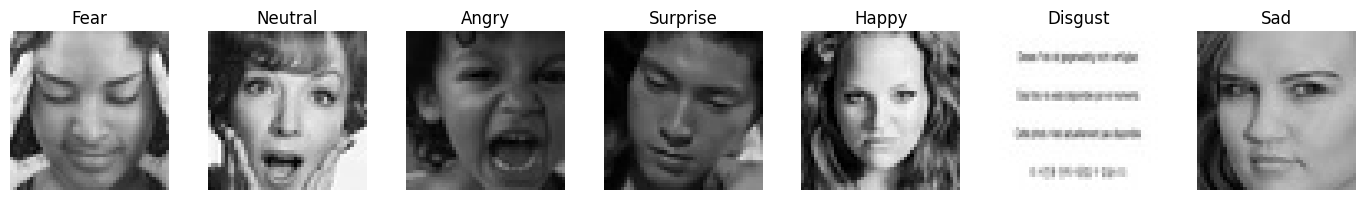

In [295]:
show_first_images_by_category_rgb(train_ds_rgb)

In [296]:
import matplotlib.pyplot as plt
import numpy as np

# Metoda koja prikazuje sliku u realnoj velicini (za poredjenje prilikom resize-a)
def show_first_image_real_size(dataset, dpi=100):
    # 1. batch
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        break
    
    # 1. slika
    image = images[0]
    
    h, w = image.shape[:2]

    fig_width = w / dpi
    fig_height = h / dpi

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    ax.imshow(image)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    plt.show()


In [297]:
def resize_images(x, y, h=128, w=128):
    #x = tf.image.resize(x, [h, w], method='nearest')
    x = tf.image.resize(x, [h, w], method=tf.image.ResizeMethod.BILINEAR)

    return x, y

<h1 style="color: #16537e">VGGNET 19</h1>
parametri (podesiti, i iz radova) i rez, analiza, fine tuning! 

In [131]:
train_ds_rgb_1 = train_ds_rgb.map(lambda x, y: resize_images(x, y, h=128, w=128))
val_ds_rgb_1   = val_ds_rgb.map(lambda x, y: resize_images(x, y, h=128, w=128))
test_ds_rgb_1  = test_ds_rgb.map(lambda x, y: resize_images(x, y, h=128, w=128))

In [87]:
for x, y in train_ds_rgb_1.take(1):
    print(x.shape) 

(128, 128, 128, 3)


Prikazujemo po jednu prvu sliku iz test skupa (jer se u njemu redoslijed slika ne mijesaja kad im se pristupa):

Dimenzije slike: (48, 48, 3)


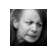

Dimenzije slike: (128, 128, 3)


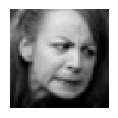

In [88]:
for x, y in train_ds_rgb.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb)

for x, y in train_ds_rgb_1.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb_1)

In [89]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parametri
img_height = 128
img_width = 128
num_classes = 7
batch_size = 256
learning_rate = 5e-3
epochs = 40

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),          
    layers.RandomRotation(0.15),              
    layers.RandomTranslation(0.15, 0.15),     
    layers.RandomZoom(0.15),                 
    layers.RandomTranslation(0.0, 0.0),      
])

# Build VGG19 model
vgg_base = VGG19(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in vgg_base.layers:
    layer.trainable = False

inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = vgg_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_ds_rgb_1,
    validation_data=val_ds_rgb_1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluate
best_model = tf.keras.models.load_model('best_vgg19_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_1)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))

Epoch 1/40
  2/181 ━━━━━━━━━━━━━━━━━━━━ 34:28 12s/step - accuracy: 0.1133 - auc: 0.4983 - loss: 2.3636 - precision: 0.0819 - recall: 0.0137  

KeyboardInterrupt: 

In [29]:
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)          │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_15 (Sequential)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_665              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,225,111 (77.15 MB)

 Trainable params: 66,823 (261.03 KB)

 Non-trainable params: 20,024,640 (76.39 MB)

 Optimizer params: 133,648 (522.07 KB)

In [11]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

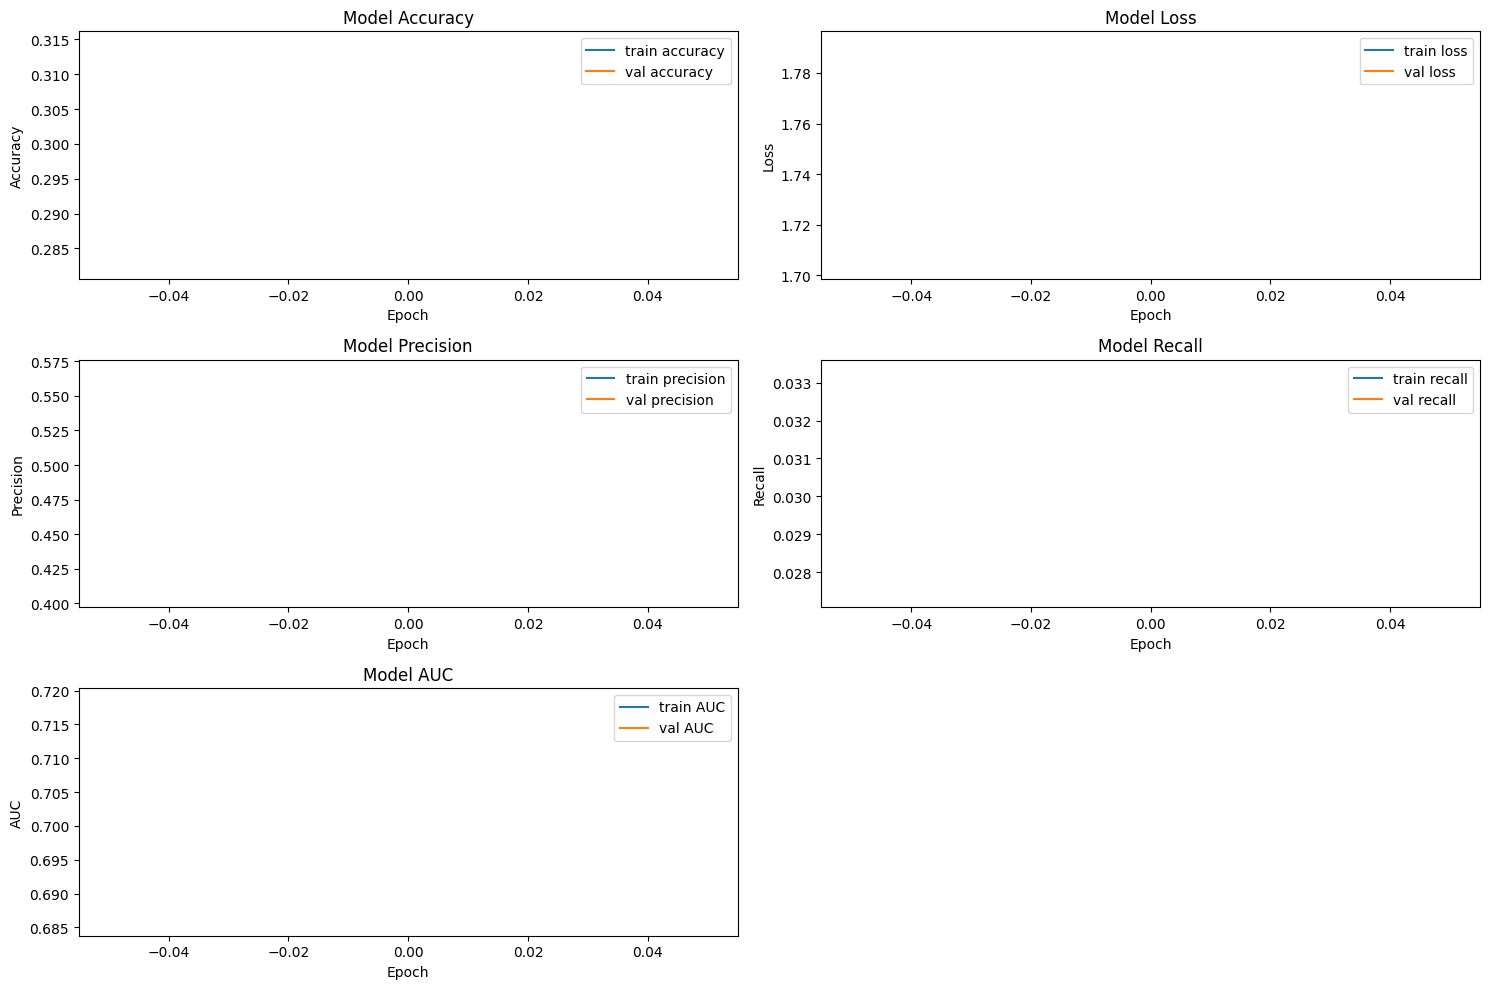

In [16]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()


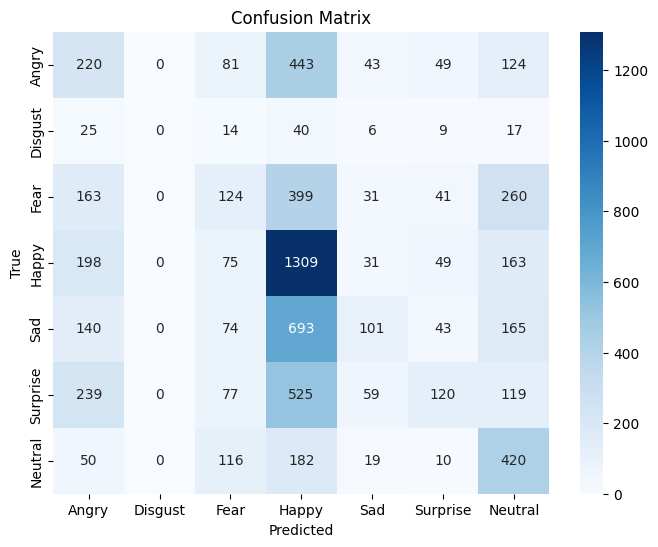

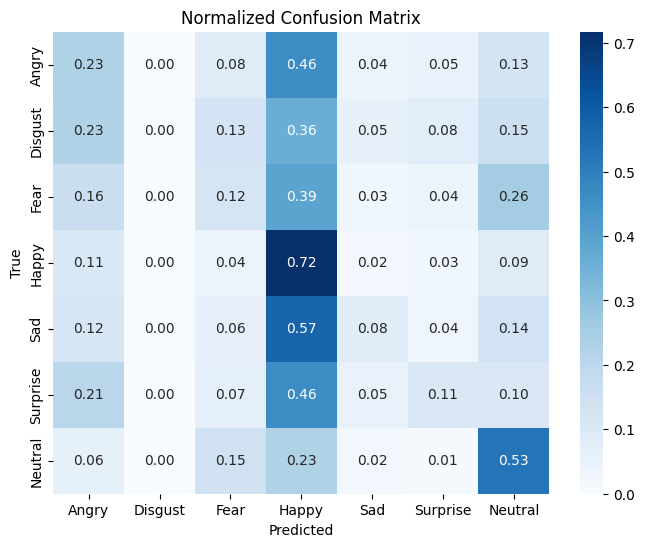

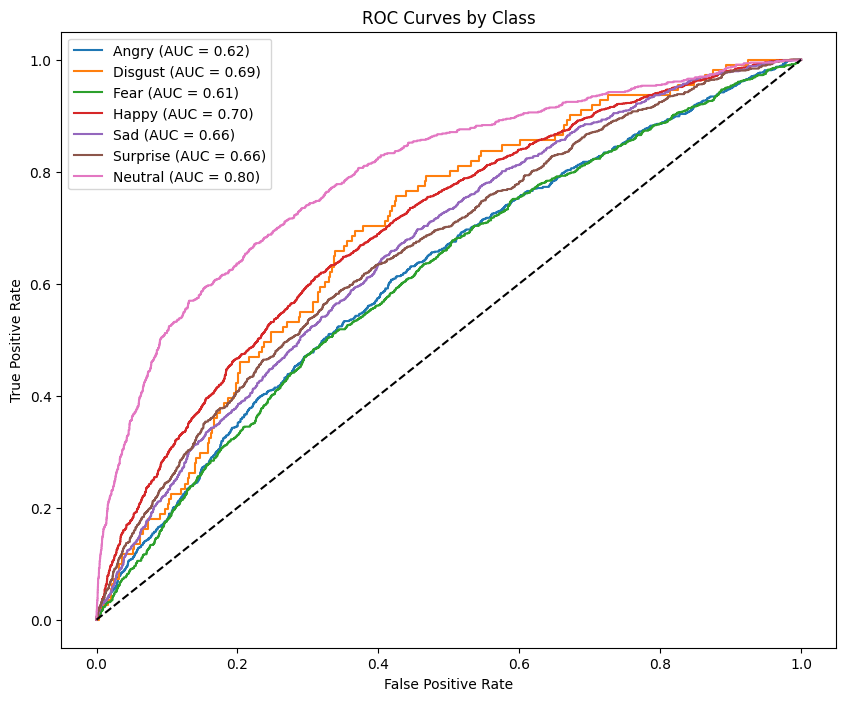

In [15]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()




<h1 style="color: #16537e">GOOGLENET INCEPTION V3</h1>

In [269]:
train_ds_rgb_2 = train_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))
val_ds_rgb_2   = val_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))
test_ds_rgb_2  = test_ds_rgb.map(lambda x, y: resize_images(x, y, h=130, w=130))

In [270]:
for x, y in train_ds_rgb_2.take(1):
    print(x.shape) 

(128, 130, 130, 3)


Dimenzije slike: (48, 48, 3)


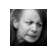

Dimenzije slike: (130, 130, 3)


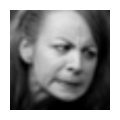

In [271]:
for x, y in train_ds_rgb.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb)

for x, y in train_ds_rgb_2.take(1):
    print(f"Dimenzije slike: {x[0].shape}")
show_first_image_real_size(test_ds_rgb_2)

In [279]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, f1_score

# Parametri
img_height = 130
img_width = 130
num_classes = 7
batch_size = 128
learning_rate = 5e-4
epochs = 40

# Data augmentation 
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.15)
])

# Build InceptionV3 model
inception_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
for layer in inception_base.layers:
    layer.trainable = False

inputs = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = inception_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_inception_model.keras', monitor='val_loss', save_best_only=True)

# Train model
history = model.fit(
    train_ds_rgb_2,
    validation_data=val_ds_rgb_2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# Evaluate
best_model = load_model('best_inception_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_2)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report 
y_true = np.concatenate([y for x, y in test_ds_rgb_2], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_2)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/40
 93/203 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - accuracy: 0.2115 - auc: 0.5872 - loss: 2.2839 - precision: 0.2444 - recall: 0.0743

KeyboardInterrupt: 

In [274]:
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)          │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_19 (Sequential)           │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1039             │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,593,335 (86.19 MB)

 Trainable params: 263,431 (1.00 MB)

 Non-trainable params: 21,803,040 (83.17 MB)

 Optimizer params: 526,864 (2.01 MB)

In [275]:
history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

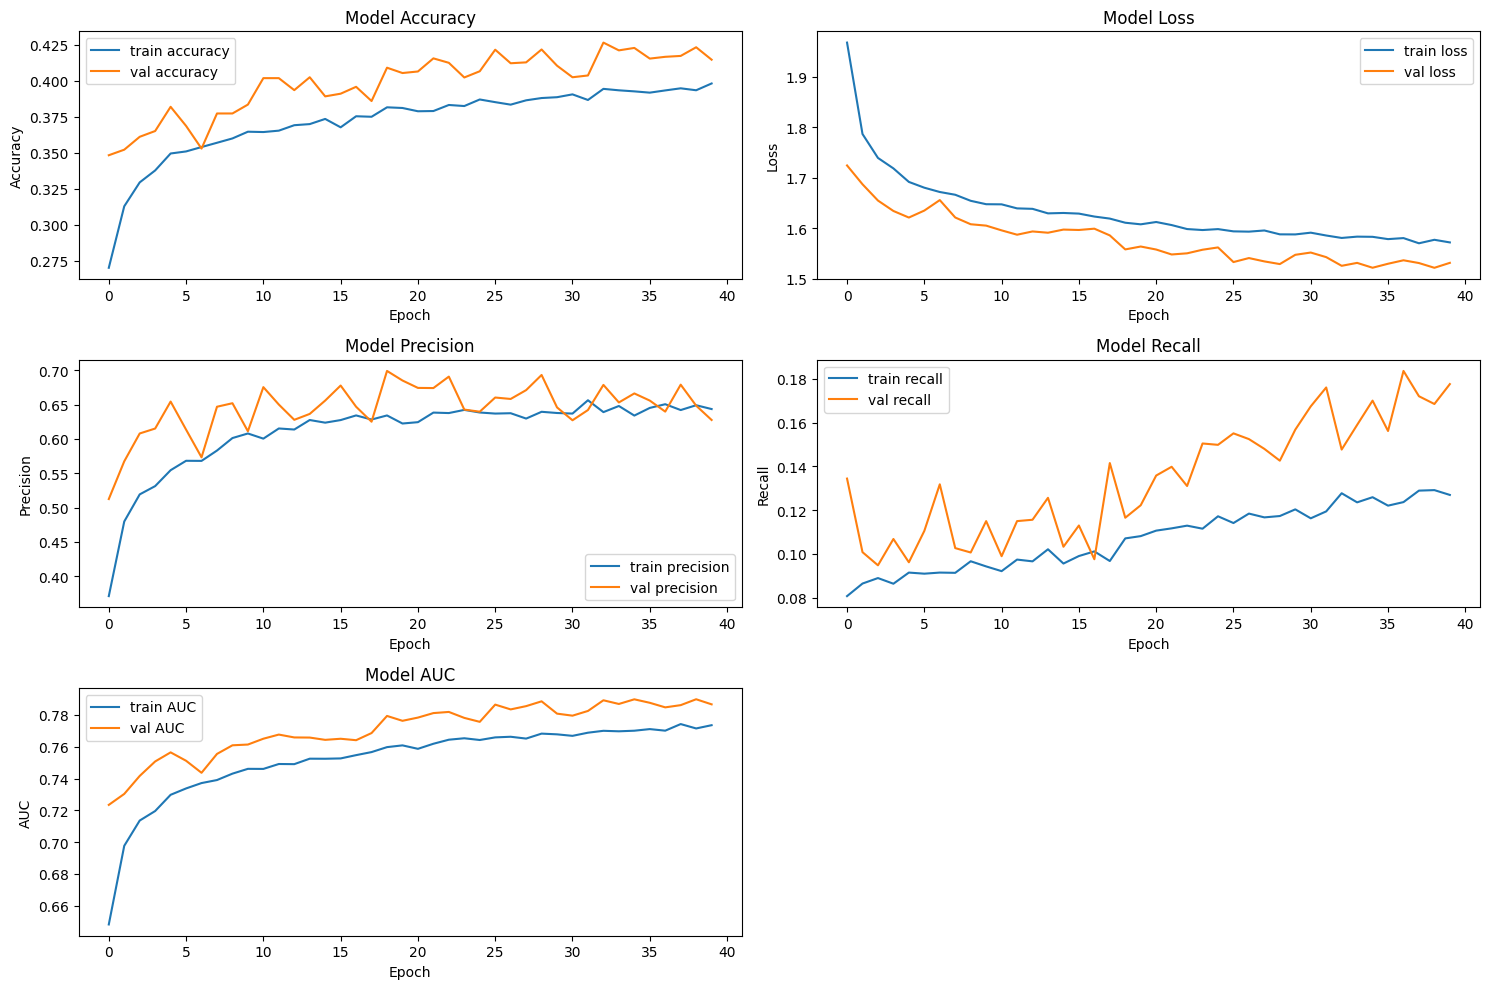

In [276]:
plt.figure(figsize=(15,10))

# Loss
plt.subplot(3,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(3,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3,2,3)
plt.plot(history.history['precision'], label='train precision')
plt.plot(history.history['val_precision'], label='val precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(3,2,4)
plt.plot(history.history['recall'], label='train recall')
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(3,2,5)
plt.plot(history.history['auc'], label='train AUC')
plt.plot(history.history['val_auc'], label='val AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()


plt.tight_layout()
plt.show()


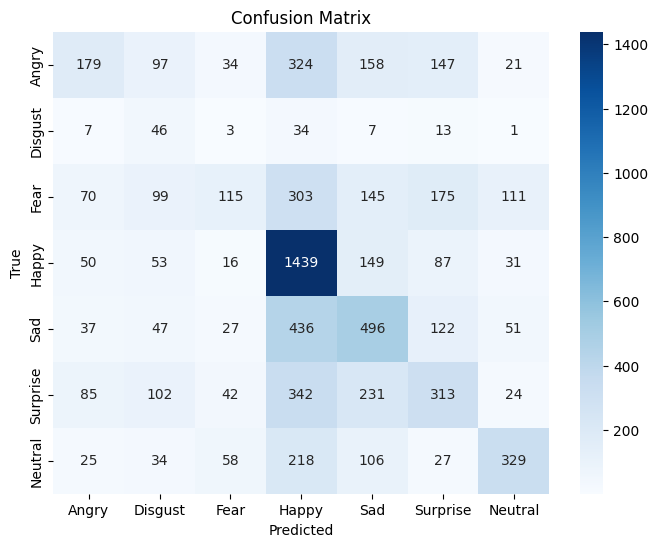

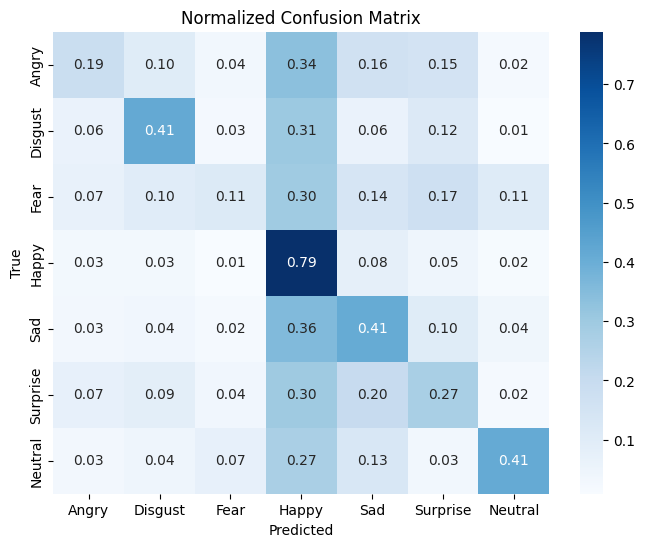

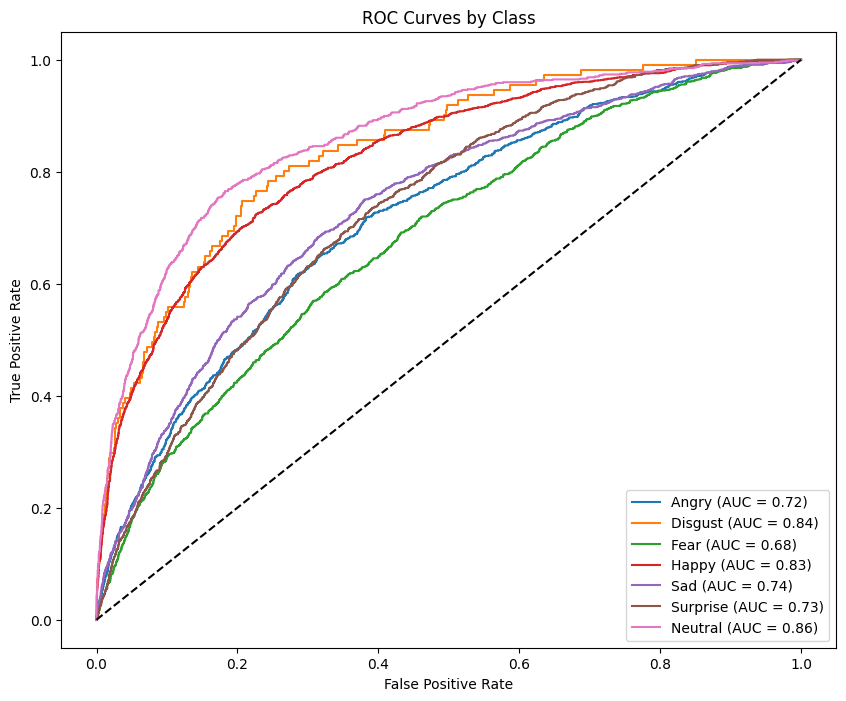

In [277]:
# Analiza performansi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import random

# Klase
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

#  1. Konfuziona matrica 
cm = confusion_matrix(y_true_classes, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Normalizovana konfuziona matrica (% umjesto brojeva)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 3. ROC krive i AUC po klasama 
y_true_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend()
plt.show()




In [278]:
# --- Fine-tuning poslednjeg bloka ---
# Otvori poslednji block za treniranje
fine_tune_epochs = 15
fine_tune_at = 249  # poslednji InceptionV3 block
for layer in inception_base.layers[:fine_tune_at]:
    layer.trainable = False
for layer in inception_base.layers[fine_tune_at:]:
    layer.trainable = True

# --- Optimizer za fine-tuning (manji LR) ---
fine_tune_optimizer = optimizers.Adam(learning_rate=learning_rate, amsgrad=True)

model.compile(
    optimizer=fine_tune_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# --- Nastavi treniranje (fine-tune) ---
history_fine = model.fit(
    train_ds_rgb_2,
    validation_data=val_ds_rgb_2,
    epochs=epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    batch_size=batch_size,
    callbacks=[early_stop, lr_scheduler, model_checkpoint]
)

# --- Evaluacija ---
best_model = load_model('best_inception_model.keras')
eval_results = best_model.evaluate(test_ds_rgb_2)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# --- F1 score i classification report ---
y_true = np.concatenate([y for x, y in test_ds_rgb_2], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb_2)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))

Epoch 40/55
203/203 ━━━━━━━━━━━━━━━━━━━━ 760s 4s/step - accuracy: 0.3787 - auc: 0.7566 - loss: 1.6240 - precision: 0.6155 - recall: 0.1332 - val_accuracy: 0.4513 - val_auc: 0.8115 - val_loss: 1.5050 - val_precision: 0.6072 - val_recall: 0.2894 - learning_rate: 5.0000e-04
Epoch 41/55
203/203 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.4578 - auc: 0.8162 - loss: 1.4393 - precision: 0.6877 - recall: 0.2212 - val_accuracy: 0.4925 - val_auc: 0.8451 - val_loss: 1.3392 - val_precision: 0.6832 - val_recall: 0.3139 - learning_rate: 5.0000e-04
Epoch 42/55
203/203 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step - accuracy: 0.4876 - auc: 0.8367 - loss: 1.3636 - precision: 0.7044 - recall: 0.2637 - val_accuracy: 0.5289 - val_auc: 0.8632 - val_loss: 1.2693 - val_precision: 0.6834 - val_recall: 0.3744 - learning_rate: 5.0000e-04
Epoch 43/55
203/203 ━━━━━━━━━━━━━━━━━━━━ 747s 4s/step - accuracy: 0.5022 - auc: 0.8464 - loss: 1.3263 - precision: 0.7156 - recall: 0.2895 - val_accuracy: 0.5343 - val_auc: 0.8680 - va

<h1 style="color: #16537e">RESNET 50</h1>

In [298]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48,48,3))

for layer in base_model.layers:
    layer.trainable = False

inputs = layers.Input(shape=(48,48,3))
x = data_augmentation(inputs)    
x = base_model(x, training=False)      
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

#Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)


loss, acc, prec, rec, auc = model.evaluate(val_ds_rgb)
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")


Epoch 1/50
 50/181 ━━━━━━━━━━━━━━━━━━━━ 1:53 867ms/step - accuracy: 0.2045 - auc: 0.5871 - loss: 1.9395 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117m

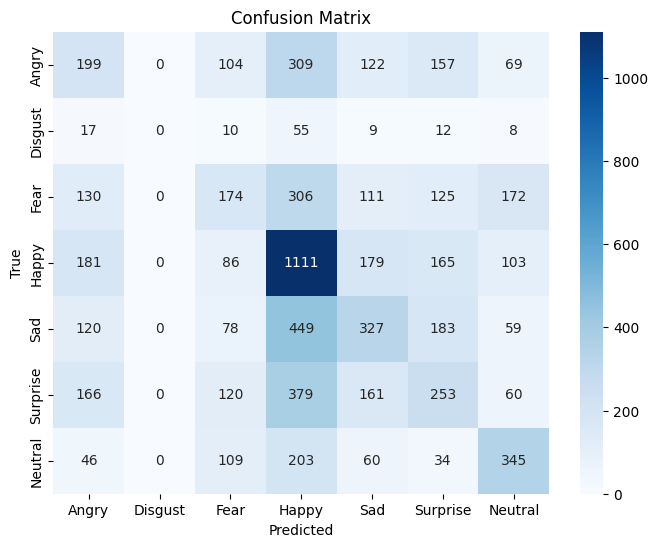

              precision    recall  f1-score   support

       Angry       0.23      0.21      0.22       960
     Disgust       0.00      0.00      0.00       111
        Fear       0.26      0.17      0.20      1018
       Happy       0.40      0.61      0.48      1825
         Sad       0.34      0.27      0.30      1216
    Surprise       0.27      0.22      0.24      1139
     Neutral       0.42      0.43      0.43       797

    accuracy                           0.34      7066
   macro avg       0.27      0.27      0.27      7066
weighted avg       0.32      0.34      0.32      7066



c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Skupljamo sve prave i predviđene vrednosti
y_true = []
y_pred = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Konfuziona matrica
cm = confusion_matrix(y_true, y_pred)

# Ako imaš 7 emocija (npr. FER2013 dataset)
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 3. Izveštaj (preciznost, recall, F1 po klasi)
print(classification_report(y_true, y_pred, target_names=class_names))


In [69]:
from tensorflow.keras.optimizers import Adam

for layer in base_model.layers[-4:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)


history_finetune = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

# Evaluacija
loss, acc, prec, rec, auc = model.evaluate(test_ds_rgb)
print(f"Fine-tuned -> Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")

Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - accuracy: 0.3270 - auc: 0.7312 - loss: 1.6801 - precision: 0.6083 - recall: 0.0203 - val_accuracy: 0.3385 - val_auc: 0.7321 - val_loss: 1.6749 - val_precision: 0.6696 - val_recall: 0.0390
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - accuracy: 0.3241 - auc: 0.7306 - loss: 1.6787 - precision: 0.6350 - recall: 0.0241 - val_accuracy: 0.3352 - val_auc: 0.7313 - val_loss: 1.6746 - val_precision: 0.6485 - val_recall: 0.0413
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.3281 - auc: 0.7305 - loss: 1.6789 - precision: 0.6421 - recall: 0.0234

181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 211ms/step - accuracy: 0.3272 - auc: 0.7321 - loss: 1.6755 - precision: 0.6346 - recall: 0.0223 - val_accuracy: 0.3380 - val_auc: 0.7361 - val_loss: 1.6667 - val_precision: 0.6270 - val_recall: 0.0484
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - accuracy: 0.3280 - auc: 0.7327 - loss: 1.6759 - precision: 0.6249 - recall: 0.0251 - val_accuracy: 0.3295 - val_auc: 0.7331 - val_loss: 1.6716 - val_precision: 0.6178 - val_recall: 0.0614
Epoch 5/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 211ms/step - accuracy: 0.3291 - auc: 0.7332 - loss: 1.6732 - precision: 0.6278 - recall: 0.0271 - val_accuracy: 0.3321 - val_auc: 0.7334 - val_loss: 1.6699 - val_precision: 0.6151 - val_recall: 0.0607
Epoch 6/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.3292 - auc: 0.7311 - loss: 1.6773 - precision: 0.6483 - recall: 0.0288

181/181 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.3290 - auc: 0.7325 - loss: 1.6741 - precision: 0.6323 - recall: 0.0274 - val_accuracy: 0.3423 - val_auc: 0.7372 - val_loss: 1.6622 - val_precision: 0.6440 - val_recall: 0.0508
Epoch 7/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3248 - auc: 0.7321 - loss: 1.6746 - precision: 0.6625 - recall: 0.0296

181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 212ms/step - accuracy: 0.3286 - auc: 0.7344 - loss: 1.6704 - precision: 0.6540 - recall: 0.0284 - val_accuracy: 0.3508 - val_auc: 0.7396 - val_loss: 1.6587 - val_precision: 0.6800 - val_recall: 0.0383
Epoch 8/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 212ms/step - accuracy: 0.3324 - auc: 0.7343 - loss: 1.6696 - precision: 0.6493 - recall: 0.0271 - val_accuracy: 0.3364 - val_auc: 0.7341 - val_loss: 1.6674 - val_precision: 0.6268 - val_recall: 0.0609
Epoch 9/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - accuracy: 0.3328 - auc: 0.7351 - loss: 1.6690 - precision: 0.6566 - recall: 0.0291 - val_accuracy: 0.3447 - val_auc: 0.7373 - val_loss: 1.6613 - val_precision: 0.6413 - val_recall: 0.0571
Epoch 10/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - accuracy: 0.3346 - auc: 0.7344 - loss: 1.6701 - precision: 0.6419 - recall: 0.0292 - val_accuracy: 0.3435 - val_auc: 0.7317 - val_loss: 1.6725 - val_precision: 0.6652 - val_recall: 0.0534
Epoch 11/20
181/181 ━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━

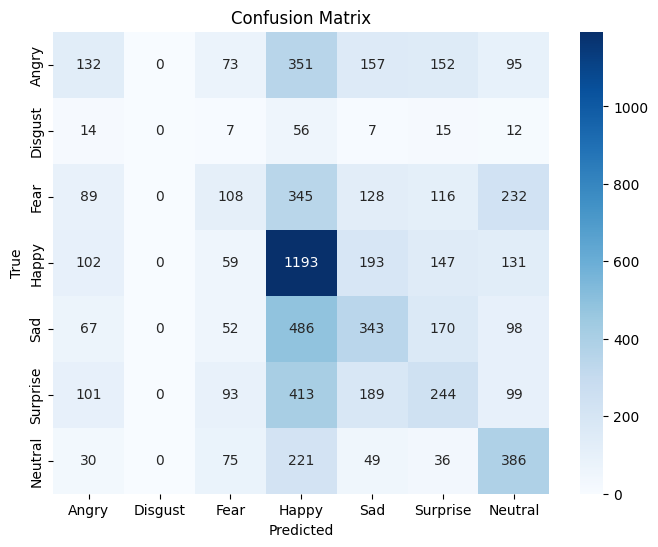

              precision    recall  f1-score   support

       Angry       0.25      0.14      0.18       960
     Disgust       0.00      0.00      0.00       111
        Fear       0.23      0.11      0.15      1018
       Happy       0.39      0.65      0.49      1825
         Sad       0.32      0.28      0.30      1216
    Surprise       0.28      0.21      0.24      1139
     Neutral       0.37      0.48      0.42       797

    accuracy                           0.34      7066
   macro avg       0.26      0.27      0.25      7066
weighted avg       0.31      0.34      0.31      7066



c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Skynet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Skupljamo sve prave i predviđene vrednosti
y_true = []
y_pred = []

for images, labels in test_ds_rgb:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Konfuziona matrica
cm = confusion_matrix(y_true, y_pred)

# Ako imaš 7 emocija (npr. FER2013 dataset)
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 3. Izveštaj (preciznost, recall, F1 po klasi)
print(classification_report(y_true, y_pred, target_names=class_names))


<h1 style="color: #16537e">MOBILENET V2</h1>

In [75]:
from tensorflow.keras.applications import MobileNetV2

# Base model bez top sloja
base_model = MobileNetV2(
    input_shape=(48,48,3),
    include_top=False,     # ukloni Dense sloj za klasifikaciju
    weights='imagenet'     # pretrained težine
)

for layer in base_model.layers:
    layer.trainable = False

inputs = layers.Input(shape=(48,48,3))
x = data_augmentation(inputs)    
x = base_model(x, training=False)      
x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

#Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)


loss, acc, prec, rec, auc = model.evaluate(test_ds_rgb)
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")


C:\Users\Skynet\AppData\Local\Temp\ipykernel_19528\1726870605.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2903 - auc: 0.6887 - loss: 1.8050 - precision: 0.4386 - recall: 0.0490

181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.3161 - auc: 0.7162 - loss: 1.7184 - precision: 0.5274 - recall: 0.0543 - val_accuracy: 0.3387 - val_auc: 0.7396 - val_loss: 1.6709 - val_precision: 0.5343 - val_recall: 0.1039
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.3478 - auc: 0.7481 - loss: 1.6367 - precision: 0.6184 - recall: 0.0862

181/181 ━━━━━━━━━━━━━━━━━━━━ 57s 311ms/step - accuracy: 0.3499 - auc: 0.7502 - loss: 1.6295 - precision: 0.6169 - recall: 0.0844 - val_accuracy: 0.3544 - val_auc: 0.7519 - val_loss: 1.6320 - val_precision: 0.5809 - val_recall: 0.0897
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.3670 - auc: 0.7596 - loss: 1.6042 - precision: 0.6321 - recall: 0.0956

181/181 ━━━━━━━━━━━━━━━━━━━━ 71s 248ms/step - accuracy: 0.3658 - auc: 0.7600 - loss: 1.6031 - precision: 0.6207 - recall: 0.0934 - val_accuracy: 0.3619 - val_auc: 0.7560 - val_loss: 1.6210 - val_precision: 0.5822 - val_recall: 0.1081
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.3737 - auc: 0.7672 - loss: 1.5878 - precision: 0.6338 - recall: 0.1066

181/181 ━━━━━━━━━━━━━━━━━━━━ 96s 325ms/step - accuracy: 0.3728 - auc: 0.7678 - loss: 1.5850 - precision: 0.6267 - recall: 0.1019 - val_accuracy: 0.3628 - val_auc: 0.7615 - val_loss: 1.6052 - val_precision: 0.6199 - val_recall: 0.1126
Epoch 5/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.3828 - auc: 0.7739 - loss: 1.5668 - precision: 0.6469 - recall: 0.1132

181/181 ━━━━━━━━━━━━━━━━━━━━ 73s 275ms/step - accuracy: 0.3821 - auc: 0.7737 - loss: 1.5675 - precision: 0.6326 - recall: 0.1086 - val_accuracy: 0.3702 - val_auc: 0.7651 - val_loss: 1.6002 - val_precision: 0.6063 - val_recall: 0.1232
Epoch 6/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 74s 228ms/step - accuracy: 0.3874 - auc: 0.7767 - loss: 1.5584 - precision: 0.6294 - recall: 0.1155 - val_accuracy: 0.3716 - val_auc: 0.7644 - val_loss: 1.6050 - val_precision: 0.5780 - val_recall: 0.1440
Epoch 7/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.3925 - auc: 0.7808 - loss: 1.5486 - precision: 0.6390 - recall: 0.1181 - val_accuracy: 0.3806 - val_auc: 0.7666 - val_loss: 1.6154 - val_precision: 0.5454 - val_recall: 0.1659
Epoch 8/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3985 - auc: 0.7854 - loss: 1.5342 - precision: 0.6390 - recall: 0.1371

181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.3979 - auc: 0.7848 - loss: 1.5357 - precision: 0.6418 - recall: 0.1291 - val_accuracy: 0.3810 - val_auc: 0.7685 - val_loss: 1.5929 - val_precision: 0.6098 - val_recall: 0.1358
Epoch 9/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.4051 - auc: 0.7866 - loss: 1.5314 - precision: 0.6409 - recall: 0.1322 - val_accuracy: 0.3798 - val_auc: 0.7700 - val_loss: 1.5931 - val_precision: 0.5843 - val_recall: 0.1587
Epoch 10/50
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4029 - auc: 0.7891 - loss: 1.5238 - precision: 0.6351 - recall: 0.1459

181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.4019 - auc: 0.7893 - loss: 1.5232 - precision: 0.6347 - recall: 0.1377 - val_accuracy: 0.3789 - val_auc: 0.7696 - val_loss: 1.5902 - val_precision: 0.5789 - val_recall: 0.1522
Epoch 11/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.4092 - auc: 0.7927 - loss: 1.5122 - precision: 0.6470 - recall: 0.1405 - val_accuracy: 0.3806 - val_auc: 0.7681 - val_loss: 1.6002 - val_precision: 0.5871 - val_recall: 0.1648
Epoch 12/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.4130 - auc: 0.7957 - loss: 1.5043 - precision: 0.6457 - recall: 0.1484 - val_accuracy: 0.3761 - val_auc: 0.7719 - val_loss: 1.5929 - val_precision: 0.5802 - val_recall: 0.1719
Epoch 13/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.4163 - auc: 0.7977 - loss: 1.4974 - precision: 0.6544 - recall: 0.1547 - val_accuracy: 0.3739 - val_auc: 0.7694 - val_loss: 1.5975 - val_precision: 0.5885 - val_recall: 0.1523
Epoch 14/50
181/181 ━━━━━━━━━━━━

In [78]:
set_trainable = False
for layer in base_model.layers:
    if layer.name.startswith("block_16"):
        set_trainable = True
    if set_trainable:
        # BatchNorm ostaje zamrznut
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True


model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

history_finetune = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

loss, acc, prec, rec, auc = model.evaluate(test_ds_rgb)
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, AUC: {auc:.3f}")

Epoch 1/15
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4474 - auc: 0.8175 - loss: 1.4308 - precision: 0.6780 - recall: 0.1959

181/181 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.4472 - auc: 0.8198 - loss: 1.4245 - precision: 0.6787 - recall: 0.1964 - val_accuracy: 0.4001 - val_auc: 0.7854 - val_loss: 1.5515 - val_precision: 0.5941 - val_recall: 0.1960
Epoch 2/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.4529 - auc: 0.8196 - loss: 1.4246 - precision: 0.6763 - recall: 0.1966 - val_accuracy: 0.4049 - val_auc: 0.7864 - val_loss: 1.5517 - val_precision: 0.5990 - val_recall: 0.1926
Epoch 3/15
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4486 - auc: 0.8201 - loss: 1.4225 - precision: 0.6843 - recall: 0.2023

181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.4542 - auc: 0.8215 - loss: 1.4173 - precision: 0.6775 - recall: 0.2009 - val_accuracy: 0.4037 - val_auc: 0.7858 - val_loss: 1.5493 - val_precision: 0.6007 - val_recall: 0.1848
Epoch 4/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.4562 - auc: 0.8235 - loss: 1.4094 - precision: 0.6907 - recall: 0.2067 - val_accuracy: 0.4039 - val_auc: 0.7878 - val_loss: 1.5504 - val_precision: 0.5828 - val_recall: 0.2130
Epoch 5/15
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4569 - auc: 0.8239 - loss: 1.4108 - precision: 0.6852 - recall: 0.2034

181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.4553 - auc: 0.8234 - loss: 1.4125 - precision: 0.6781 - recall: 0.2029 - val_accuracy: 0.4056 - val_auc: 0.7889 - val_loss: 1.5472 - val_precision: 0.5913 - val_recall: 0.2073
Epoch 6/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.4550 - auc: 0.8244 - loss: 1.4093 - precision: 0.6813 - recall: 0.2047 - val_accuracy: 0.4072 - val_auc: 0.7887 - val_loss: 1.5482 - val_precision: 0.5973 - val_recall: 0.2056
Epoch 7/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.4593 - auc: 0.8262 - loss: 1.4020 - precision: 0.6899 - recall: 0.2082 - val_accuracy: 0.4044 - val_auc: 0.7887 - val_loss: 1.5490 - val_precision: 0.5989 - val_recall: 0.2054
Epoch 8/15
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4599 - auc: 0.8256 - loss: 1.4045 - precision: 0.6900 - recall: 0.2096

181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.4576 - auc: 0.8265 - loss: 1.4020 - precision: 0.6898 - recall: 0.2066 - val_accuracy: 0.4032 - val_auc: 0.7882 - val_loss: 1.5454 - val_precision: 0.6001 - val_recall: 0.2002
Epoch 9/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.4652 - auc: 0.8287 - loss: 1.3938 - precision: 0.6894 - recall: 0.2188 - val_accuracy: 0.4074 - val_auc: 0.7887 - val_loss: 1.5527 - val_precision: 0.5890 - val_recall: 0.2158
Epoch 10/15
180/181 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4668 - auc: 0.8306 - loss: 1.3860 - precision: 0.6922 - recall: 0.2240

181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.4638 - auc: 0.8287 - loss: 1.3924 - precision: 0.6883 - recall: 0.2193 - val_accuracy: 0.4077 - val_auc: 0.7902 - val_loss: 1.5437 - val_precision: 0.5906 - val_recall: 0.2103
Epoch 11/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.4651 - auc: 0.8293 - loss: 1.3916 - precision: 0.6915 - recall: 0.2164 - val_accuracy: 0.4075 - val_auc: 0.7902 - val_loss: 1.5530 - val_precision: 0.5810 - val_recall: 0.2235
Epoch 12/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - accuracy: 0.4628 - auc: 0.8292 - loss: 1.3918 - precision: 0.6921 - recall: 0.2186 - val_accuracy: 0.4089 - val_auc: 0.7906 - val_loss: 1.5453 - val_precision: 0.5875 - val_recall: 0.2189
Epoch 13/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - accuracy: 0.4663 - auc: 0.8316 - loss: 1.3835 - precision: 0.6945 - recall: 0.2204 - val_accuracy: 0.4091 - val_auc: 0.7901 - val_loss: 1.5438 - val_precision: 0.5978 - val_recall: 0.2110
Epoch 14/15
180/181 ━━━━━━━━

181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.4686 - auc: 0.8307 - loss: 1.3864 - precision: 0.6910 - recall: 0.2199 - val_accuracy: 0.4101 - val_auc: 0.7917 - val_loss: 1.5359 - val_precision: 0.6018 - val_recall: 0.2139
Epoch 15/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - accuracy: 0.4685 - auc: 0.8321 - loss: 1.3827 - precision: 0.6953 - recall: 0.2215 - val_accuracy: 0.4115 - val_auc: 0.7930 - val_loss: 1.5379 - val_precision: 0.5988 - val_recall: 0.2209
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4161 - auc: 0.7942 - loss: 1.5256 - precision: 0.5870 - recall: 0.2181
Accuracy: 0.416, Precision: 0.587, Recall: 0.218, AUC: 0.794


<h1 style="color: #16537e">BASELINE CNN</h1>

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Parametri
img_height = 48
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 1e-4

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

# Build baseline CNN
inputs = layers.Input(shape=(img_height, img_width, 3))  
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'),
             metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_baseline_cnn.keras', monitor='val_loss', save_best_only=True)

# Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=50,
    callbacks=[early_stop, model_checkpoint]
)

# Evaluate
best_model = tf.keras.models.load_model('best_baseline_cnn.keras')
eval_results = best_model.evaluate(test_ds_rgb)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.2306 - auc: 0.5997 - loss: 1.9112 - precision: 0.2847 - recall: 0.0017 - val_accuracy: 0.2516 - val_auc: 0.6654 - val_loss: 1.8935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.3106 - auc: 0.6843 - loss: 1.7952 - precision: 0.5023 - recall: 0.0047 - val_accuracy: 0.3026 - val_auc: 0.7042 - val_loss: 1.8254 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3526 - auc: 0.7255 - loss: 1.7087 - precision: 0.6667 - recall: 0.0352 - val_accuracy: 0.3584 - val_auc: 0.7444 - val_loss: 1.7083 - val_precision: 0.8235 - val_recall: 0.0024
Epoch 4/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3743 - auc: 0.7527 - loss: 1.6406 - precision: 0.7025 - recall: 0.0762 - val_accuracy: 0.3999 - val_auc: 0.7629 - val_loss: 1.6137 - val_precision: 0.8173 - val_recall: 0.0605
Epoch 5/50
1

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Parametri
img_height = 48
img_width = 48
batch_size = 128
num_classes = 7
learning_rate = 1e-3

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
    # layers.RandomZoom(0.1),
])

# Build baseline CNN
inputs = layers.Input(shape=(img_height, img_width, 3))  
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
# x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', metrics.Precision(name='precision'),
             metrics.Recall(name='recall'), metrics.AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_baseline_cnn.keras', monitor='val_loss', save_best_only=True)

# Train
history = model.fit(
    train_ds_rgb,
    validation_data=val_ds_rgb,
    epochs=100,
    callbacks=[early_stop, model_checkpoint]
)

# Evaluate
best_model = tf.keras.models.load_model('best_baseline_cnn.keras')
eval_results = best_model.evaluate(test_ds_rgb)
print("Test results (loss, accuracy, precision, recall, AUC):", eval_results)

# F1 score i classification report
y_true = np.concatenate([y for x, y in test_ds_rgb], axis=0)
y_pred_prob = best_model.predict(test_ds_rgb)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

f1 = f1_score(y_true_classes, y_pred, average='weighted', zero_division=0)
print("F1 score:", f1)
print(classification_report(y_true_classes, y_pred, digits=4, zero_division=0))


Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.2494 - auc: 0.6510 - loss: 1.8600 - precision: 0.3043 - recall: 0.0118 - val_accuracy: 0.2549 - val_auc: 0.6852 - val_loss: 1.7710 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.3386 - auc: 0.7331 - loss: 1.6734 - precision: 0.5944 - recall: 0.0650 - val_accuracy: 0.3787 - val_auc: 0.7633 - val_loss: 1.6218 - val_precision: 0.8232 - val_recall: 0.0234
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.3904 - auc: 0.7754 - loss: 1.5634 - precision: 0.6729 - recall: 0.1397 - val_accuracy: 0.4209 - val_auc: 0.7992 - val_loss: 1.4978 - val_precision: 0.7743 - val_recall: 0.1381
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.4238 - auc: 0.8020 - loss: 1.4827 - precision: 0.7001 - recall: 0.1729 - val_accuracy: 0.4636 - val_auc: 0.8249 - val_loss: 1.4092 - val_precision: 0.7201 - val_recall: 0.2151
Epoch 5/100
